# Machine Learning, Exercise set #4

## 2. Polynomial linear regression

### Model specification
Given locations $x_1, \ldots, x_n$ (scalars or vectors) and measurements $y = y_1, \ldots, y_n$ (scalars), we want to find a good model that maps locations onto values.  
Let $X$ be the location matrix that contains $x_1, \ldots, x_n$ as rows.  

We use a linear model $Xw$ with weight vector $w$ and assume that the measured values $y$ are Gaussian distributed around $Xw$:

$$\mathcal{L}(w\mid y) = p(y\mid X,w) = \mathcal{N}(y\mid Xw,\Sigma)$$

We assume that the data is iid (independent identically distributed), so the likelihood factorizes:

$$\mathcal{L}(w\mid y) = p(y\mid X,w) = \prod_{i=1}^n p(y_i\mid x_i,w)$$

### Maximum likelihood estimation (MLE)
We find good parameters by maximizing the (log-)likelihood:

$$w_\text{ML} = \text{arg}\max_w \log\mathcal{L}(w\mid y)$$

For our assumption $\mathcal{L}(w\mid y) = \mathcal{N}(y\mid Xw,\Sigma)$, we get the method of ordinary least squares (OLS):

$$\begin{aligned}
w_\text{OLS} & = \text{arg}\min_w \sum_{i=1}^n(y_i-x_i^Tw)^2 \\
& = (X^TX)^{-1}X^Ty
\end{aligned}$$

which can also be written as a linear system:

$$Aw_\text{OLS} = b\\\begin{aligned}A & = X^TX\\b & = X^Ty\end{aligned}$$

### Basis function expansion
We can get a function that is nonlinear in $x$, by replacing $X$ with $\phi(X)$, e.g. the polynomial basis function (assuming $x_i$ are scalars):

$$\phi(X) = \begin{bmatrix}
    \vert&\vert& \vert& \vert&\vert \\
    1 & x &x^2 &\dots & x^d \\
    \vert& \vert& \vert& \vert& \vert
\end{bmatrix}$$

The model is still linear, since it is linear in $w$.

### Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = np.loadtxt('data/ex4_3_train.csv', delimiter=',')
test = np.loadtxt('data/ex4_3_test.csv', delimiter=',')
val = np.loadtxt('data/ex4_3_val.csv', delimiter=',')
print(train.shape, test.shape, val.shape)

xtrain, ytrain = train[:,:1], train[:,1:]
xval, yval = val[:,:1], val[:,1:]
xtest, ytest = test[:,:1], test[:,1:]

(60, 2) (30, 2) (30, 2)


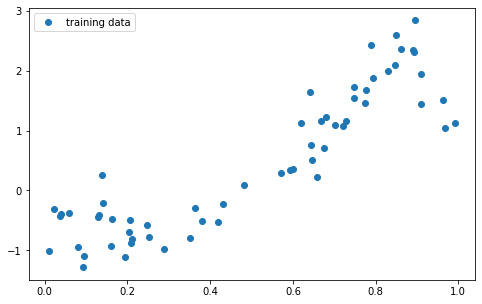

In [3]:
plt.figure(figsize=(8,5))
plt.scatter(xtrain, ytrain, label='training data')
plt.legend(loc='upper left');

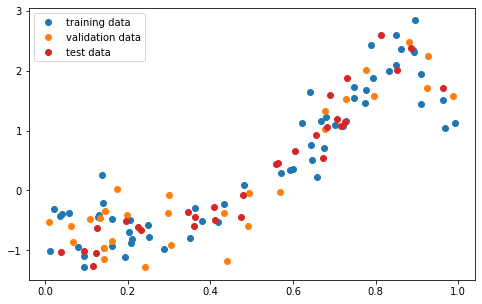

In [4]:
plt.figure(figsize=(8,5))
plt.scatter(xtrain, ytrain, label='training data')
plt.scatter(xval, yval, label='validation data')
plt.scatter(xtest, ytest, label='test data', c='C3')
plt.legend(loc='upper left');

### Ordinary least squares

#### (a) Write a function that generates the matrix X.

In [5]:
def polynomial_features(x, deg):
    X = np.repeat(x, deg + 1, axis=1)
    X[:,0] = 1.
    X = np.cumprod(X, axis=1)
    return X

#### (b) Implement the estimator $w_\text{MLE}$.

In [6]:
def ordinary_least_squares(X, y):
    #np.linalg.inv(X.T @ X) @ (X.T @ y)
    return np.linalg.solve(X.T @ X, X.T @ y)

#### (c) Implement a function that calculates the error $\text{MSE}(w)$.

In [7]:
def MSE(y, y_pred):
    return np.mean((y - y_pred)**2)

#### Simple OLS on the training set:

Train error: 0.09624939681994696
Test error: 0.10226158553327978


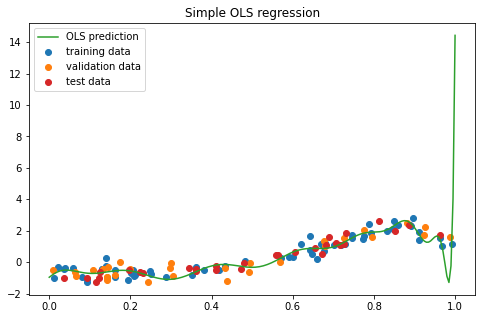

In [8]:
X = polynomial_features(xtrain, deg=40)
w_ols = ordinary_least_squares(X, ytrain)

xplot = np.linspace(0., 1., num=200)[:,np.newaxis]
yplot = polynomial_features(xplot, deg=40) @ w_ols

plt.figure(figsize=(8,5))
plt.title('Simple OLS regression')
plt.scatter(xtrain, ytrain, label='training data')
plt.scatter(xval, yval, label='validation data')
plt.scatter(xtest, ytest, label='test data', c='C3')
plt.plot(xplot, yplot, c='C2', label='OLS prediction')
plt.legend()

print('Train error:', MSE(ytrain, X @ w_ols))
print('Test error:', MSE(ytest, polynomial_features(xtest, deg=40) @ w_ols))

#### (d) Try to find a good polynomial degree $d < 20$ that leads to a small validation error.

In [9]:
#print(np.linalg.a(polynomial_features(xtrain, deg=200)))

Best polynomial degree: 4

Train error: 0.12257556789476805
Test error: 0.0962284583232134


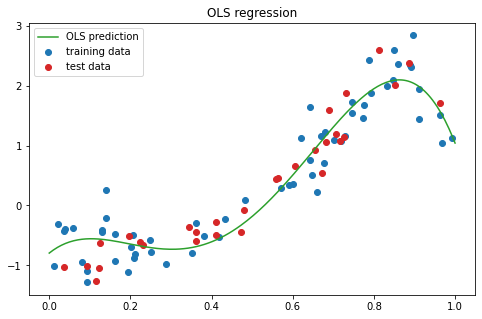

In [22]:
train_results = []
val_results = []

degs = np.arange(1, 51)
for deg in degs:
    X = polynomial_features(xtrain, deg)
    w_ols = ordinary_least_squares(X, ytrain)
    
    pred_train = X @ w_ols
    pred_val = polynomial_features(xval, deg) @ w_ols
    
    train_err = MSE(ytrain, pred_train)
    val_err = MSE(yval, pred_val)
    
    train_results.append((deg, train_err, w_ols))
    val_results.append((deg, val_err, w_ols))

# sort by validation error
val_results_sorted = sorted(val_results, key=lambda result: result[1])
best_deg, _, best_w = val_results_sorted[0]
print('Best polynomial degree: {}\n'.format(best_deg))
print('Train error:', train_results[best_deg - 1][1])
print('Test error:', MSE(ytest, polynomial_features(xtest, best_deg) @ best_w))

xplot = np.linspace(0., 1., num=200)[:,np.newaxis]
yplot = polynomial_features(xplot, best_deg) @ best_w

plt.figure(figsize=(8,5))
plt.title('OLS regression')
plt.scatter(xtrain, ytrain, label='training data')
#plt.scatter(xval, yval, label='validation data')
plt.scatter(xtest, ytest, label='test data', c='C3')
plt.plot(xplot, yplot, c='C2', label='OLS prediction')
plt.legend(loc='upper left');

#### (e) Plot the training and validation/test errors against the degree of the polynomial.

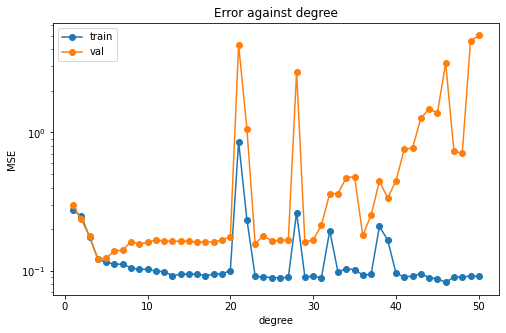

In [24]:
train_errs = [result[1] for result in train_results]
val_errs = [result[1] for result in val_results]

plt.figure(figsize=(8,5))
plt.title('Error against degree')
plt.xlabel('degree')
plt.ylabel('MSE')
plt.yscale('log')
plt.plot(degs, train_errs, marker='o',label='train')
plt.plot(degs, val_errs, marker='o', label='val')
plt.legend();

### Ridge regression (L2-regularization)
The main idea behind Ridge regression is to penalize huge parameters to reduce overfitting.  
We do this by putting a zero-mean Gaussian prior on $w$ to keep it small:

$$p(w) = \mathcal{N}(w\mid 0,\tau^2I)$$

### Maximum a posteriori estimation (MAP)
To incorporate the prior on $w$, we maximize the posterior:

$$\begin{aligned}
w_\text{MAP} & = \text{arg}\max_w p(w\mid X,y) \\
& = \text{arg}\max_w \frac{p(y\mid X,w) p(w\mid X)}{p(y\mid X)} \\
& = \text{arg}\max_w p(y\mid X,w) p(w)
\end{aligned}$$

For our assumptions $\mathcal{L}(w\mid y) = \mathcal{N}(y\mid Xw,\Sigma)$ and $p(w) = \mathcal{N}(w\mid 0,\tau^2I)$, we obtain ridge regression:

$$\begin{aligned}
w_\text{ridge} & = \text{arg}\min_w \sum_{i=1}^n(y_i-x_i^Tw)^2+\lambda \lVert w \rVert_2^2 \\
& = (\lambda I + X^TX)^{-1}X^Ty
\end{aligned}$$

where $\lambda$ is a hyperparameter that must be finetuned. Again, this can be written as a linear system:

$$Aw_\text{ridge} = b\\\begin{aligned}A & = \lambda I + X^TX\\b & = X^Ty\end{aligned}$$

#### (f) Implement the estimator $w_\text{ridge}$.

In [25]:
def ridge_regression(X, y, lamda):
    A = X.T @ X + lamda * np.eye(X.shape[1])
    b = X.T @ y
    return np.linalg.solve(A, b)

#### (g) Find a good combination of $d$ and $\lambda$ that gives you a small validation error.

Best hyperparameters: d = 5, λ = 3.792690190732254e-05

Train error: 0.11735800134225419
Test error: 0.08572924078281598


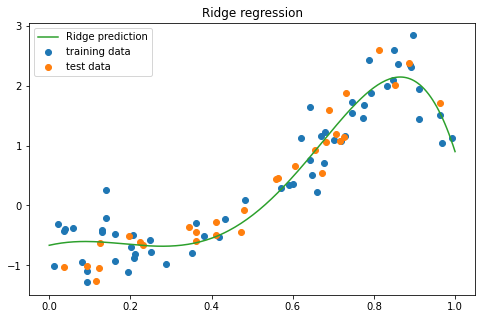

In [26]:
best_val_err = np.inf
best_deg = None
best_lamda = None
best_w = None

for deg in range(1, 21):
    for lamda in np.logspace(-6., 0., num=20):
        X = polynomial_features(xtrain, deg)
        w_ridge = ridge_regression(X, ytrain, lamda)
        
        pred_val = polynomial_features(xval, deg) @ w_ridge
        val_err = MSE(yval, pred_val)
        
        if val_err < best_val_err:
            best_val_err = val_err
            best_deg = deg
            best_lamda = lamda
            best_w = w_ridge

print('Best hyperparameters: d = {}, λ = {}\n'.format(best_deg, best_lamda))

xplot = np.linspace(0., 1., num=200)[:,np.newaxis]
yplot = polynomial_features(xplot, best_deg) @ best_w

plt.figure(figsize=(8,5))
plt.title('Ridge regression')
plt.scatter(xtrain, ytrain, label='training data')
plt.scatter(xtest, ytest, label='test data')
plt.plot(xplot, yplot, label='Ridge prediction', c='C2')
plt.legend()

print('Train error:', MSE(ytrain, polynomial_features(xtrain, best_deg) @ best_w))
print('Test error:', MSE(ytest, polynomial_features(xtest, best_deg) @ best_w))

## Outlook on other regression methods

### Support vector regression (SVR)

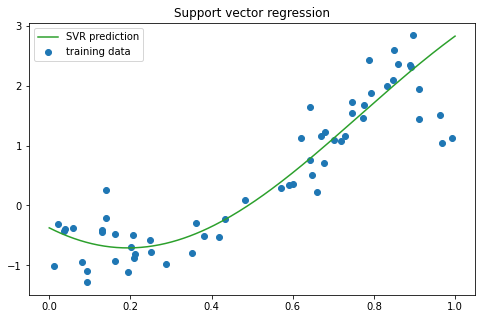

In [31]:
from sklearn import svm, gaussian_process, neighbors

kernel = gaussian_process.kernels.ConstantKernel() * gaussian_process.kernels.RBF()
svr = svm.SVR(kernel=kernel, C=1e2, gamma=0.1)
svr.fit(xtrain, ytrain.reshape(-1))

xplot = np.linspace(0., 1., num=200)[:,np.newaxis]
yplot = svr.predict(xplot)

plt.figure(figsize=(8,5))
plt.title('Support vector regression')
plt.scatter(xtrain, ytrain, label='training data')
plt.plot(xplot, yplot, c='C2', label='SVR prediction')
plt.legend(loc='upper left');

### KNN-Regression

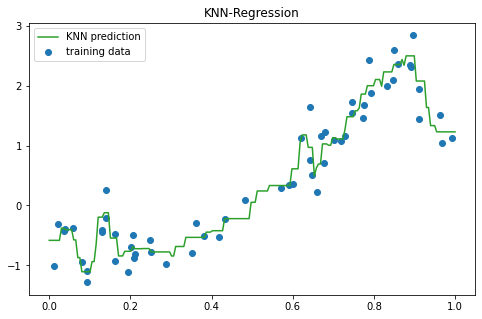

In [32]:
knn = neighbors.KNeighborsRegressor(3)
knn.fit(xtrain, ytrain)

xplot = np.linspace(0., 1., num=200)[:,np.newaxis]
yplot = knn.predict(xplot)

plt.figure(figsize=(8,5))
plt.title('KNN-Regression')
plt.scatter(xtrain, ytrain, label='training data')
plt.plot(xplot, yplot, c='C2', label='KNN prediction')
plt.legend(loc='upper left');

### Gaussian process regression

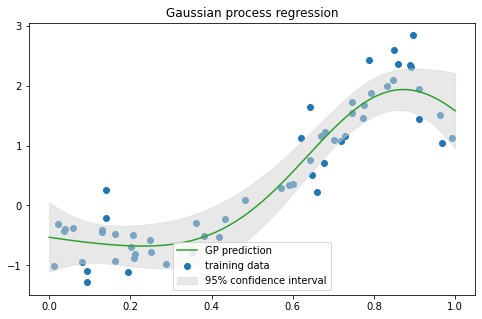

In [33]:
kernel = gaussian_process.kernels.ConstantKernel() * gaussian_process.kernels.RBF()
gp = gaussian_process.GaussianProcessRegressor(kernel, alpha=0.5, n_restarts_optimizer=20)
gp.fit(xtrain, ytrain)

xplot = np.linspace(0., 1., num=200)[:,np.newaxis]
yplot, sigma = gp.predict(xplot, return_std=True)
yplot = yplot.reshape(-1)

plt.figure(figsize=(8,5))
plt.title('Gaussian process regression')
plt.scatter(xtrain, ytrain, label='training data')
plt.plot(xplot, yplot, c='C2', label='GP prediction')
plt.fill_between(xplot.reshape(-1), yplot - 1.9600 * sigma, yplot + 1.9600 * sigma,
                 color='lightgray', alpha=0.5, label='95% confidence interval')
plt.legend(loc='lower center');

More on Gaussian Processes soon...